## Define a custom segmentation pytorch Dataset

In [2]:
import torch
from torch.utils.data.dataset import Dataset
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.transforms import functional as F
import cv2
import numpy as np

torch.manual_seed(17)

/home/cstrauss/anaconda3/envs/progo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class PILToTensor:
    def __call__(self, image, target):
        image = F.pil_to_tensor(image)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, folder_path, geometricTransform=None, colorTransform=None):
        self.img_files = glob.glob(os.path.join(folder_path, '*.jpg'))
        #print(self.img_files)
        self.mask_files = []
        self.geometricTransform = geometricTransform
        self.colorTransform = colorTransform
        for img_path in self.img_files:
            self.mask_files.append(img_path + "_skyMask.png")

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        image = Image.open(img_path)
        label = Image.open(mask_path)
        if self.colorTransform:
            image = self.colorTransform(image)
        if self.geometricTransform:
            image = self.geometricTransform(image)
            label = self.geometricTransform(label)

        return PILToTensor()(image, label)

    def __len__(self):
        return len(self.img_files)


## Get random image + mask in original form

test if everything is allright

In [5]:
def display(img, mask):
    img = img.permute(1, 2, 0)
    img.shape

    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img)
    ax1.set_title('RGB image')

    ax2.imshow(label, cmap="gray")
    ax2.set_title('Sky binary mask')

<Figure size 640x480 with 0 Axes>

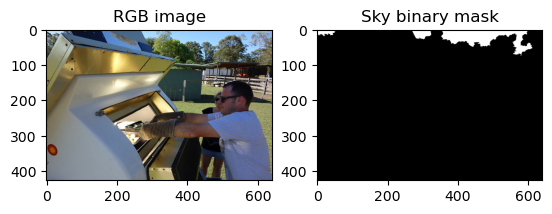

In [6]:
import random

rawDataset = SegmentationDataset('/home/cstrauss/PERSO/progo/orpogSkySeg/00_Dataset/cocoSky', None, None)

img, label = rawDataset[random.randint(0, len(rawDataset))]
display(img, label)



## Torch train / test split

In [7]:

train_ratio = 0.8
train_size = round(len(rawDataset) * train_ratio)
test_size = len(rawDataset) - train_size
train_set, val_set = torch.utils.data.random_split(rawDataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

print( "train size: ", len(train_set), " test_size: ", len(val_set))

train size:  1342  test_size:  335


## Pytorch DataLoader

In [9]:
from torchvision import datasets, transforms

image_size = (64,64)

geometricTransforms = transforms.Compose([transforms.Resize(image_size),
                               ])

colorTransforms = transforms.Compose([transforms.ColorJitter(brightness=.1, hue=.05),                                      
                               ])


segmentationDataset = SegmentationDataset('/home/cstrauss/PERSO/progo/orpogSkySeg/00_Dataset/cocoSky', geometricTransforms, colorTransforms)
len(segmentationDataset)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(segmentationDataset, batch_size=5, shuffle=True)

Feature batch shape: torch.Size([5, 3, 64, 64])
Labels batch shape: torch.Size([5, 64, 64])


<Figure size 640x480 with 0 Axes>

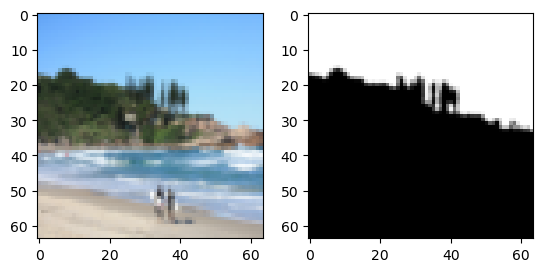

In [10]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].permute(1, 2, 0)
label = train_labels[0].squeeze()
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(img, cmap="gray")
axarr[1].imshow(label, cmap="gray")
